In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def create_homogeneous_matrix(xyz, quat):
    T = np.eye(4)
    T[:3, :3] = R.from_quat(quat).as_matrix()
    T[:3, 3] = xyz
    return T

# Load the states from the saved file
states = np.load("states_no_filter1.npy")

# Reference End-Effector Pose
ref_pos = np.array([0.50418126, 0.09185436, 0.48143709])
ref_orient = np.array([-0.99837866, 0.01344973, -0.05489271, 0.00677801])

# Extract positions and yaw angles
x_pos, y_pos, z_pos = states[:, 0], states[:, 1], states[:, 2]
yaw_angles = np.rad2deg(states[:, -1])

# Ground truth data
gt_pos = np.array([0.54312321, 0.09831869, 0.48143709])
gt_orient = np.array([0.94976577, -0.30805505, 0.05431180, 0.00986366])
gt_yaw_angle = np.rad2deg(np.arctan2(2*(gt_orient[0]*gt_orient[1] + gt_orient[2]*gt_orient[3]),
                                     1 - 2*(gt_orient[1]**2 + gt_orient[2]**2)))

# Prior data (transformation matrix)
prior_transform = np.array([[ 0.81135922,  0.5761315,   0.09883681,  0.0600903 ],
                            [-0.57745375,  0.81623445, -0.01756387,  0.3153969 ],
                            [-0.0907931,  -0.04282308,  0.99494864,  0.04048643],
                            [ 0.,          0.,          0.,          1.        ]])
prior_transform = prior_transform @ create_homogeneous_matrix(ref_pos, ref_orient)
prior_pos = prior_transform[:3, 3]
prior_yaw_angle = np.rad2deg(np.arctan2(prior_transform[1, 0], prior_transform[0, 0]))
# Combine ground truth into a single vector
gt_state = np.array([gt_pos[0], gt_pos[1], gt_pos[2], gt_yaw_angle])
prior_state = np.array([prior_pos[0], prior_pos[1], prior_pos[2], prior_yaw_angle])

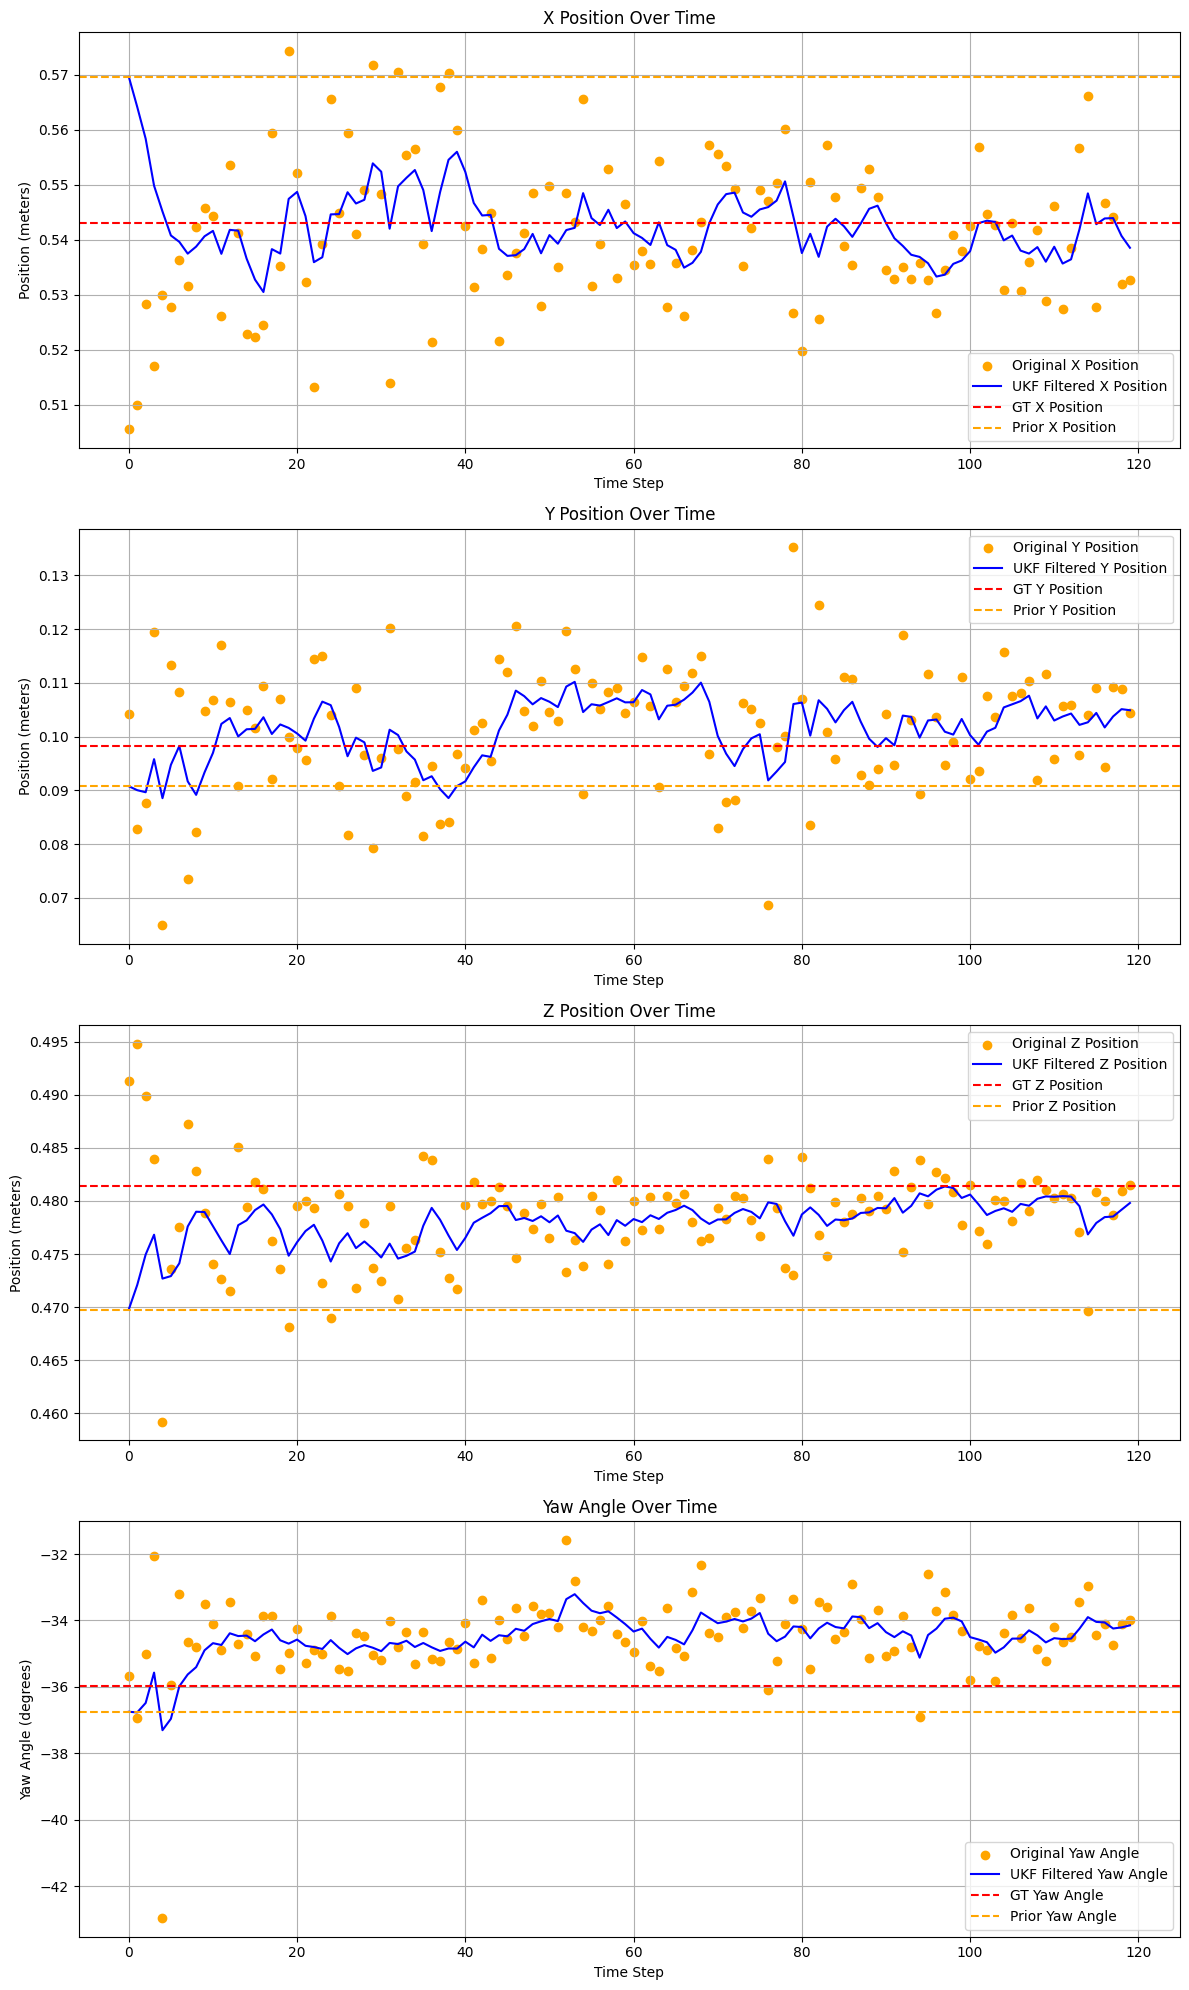

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Define the state transition and measurement functions for the UKF
def fx(x, dt):
    return x  # Identity function for state transition (no dynamics in this simple case)

def hx(x):
    return x  # Identity function for measurement (we directly measure all states)

# Initialize the UKF parameters
dim_x = 4  # Number of state variables (x, y, z, yaw)
dim_z = 4  # Number of measurement variables (x, y, z, yaw)

# Define the sigma points
points = MerweScaledSigmaPoints(n=dim_x, alpha=0.05, beta=3.0, kappa=3-4)

# Initialize the UKF
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=fx, hx=hx, dt=1.0, points=points)

# Set the initial state
ukf.x = prior_state

# Define initial covariance matrix
ukf.P *= 0.01

# Process noise covariance
ukf.Q = np.eye(dim_x)

ukf.R = np.eye(4) * 10
# Load the states from the saved file
states = np.load("states_no_filter1.npy")

# Extract positions and yaw
x_pos = states[:, 0]
y_pos = states[:, 1]
z_pos = states[:, 2]
yaw_angles = np.rad2deg(states[:, -1])  # Convert yaw from radians to degrees

# Combine into a single matrix for filtering
measurements = np.column_stack((x_pos, y_pos, z_pos, yaw_angles))

# Apply the UKF to the data
filtered_states = []

for i in range(len(measurements)):
    
    # UKF predict and update steps
    ukf.predict()
    ukf.update(measurements[i])
    # Store the filtered state
    filtered_states.append(ukf.x.copy())

# Convert filtered states to a numpy array
filtered_states = np.array(filtered_states)

# Define the plot settings for each state variable
plot_settings = [
    (x_pos, filtered_states[:, 0], gt_state[0], prior_state[0], 'X Position', 'Position (meters)'),
    (y_pos, filtered_states[:, 1], gt_state[1], prior_state[1], 'Y Position', 'Position (meters)'),
    (z_pos, filtered_states[:, 2], gt_state[2], prior_state[2], 'Z Position', 'Position (meters)'),
    (yaw_angles, filtered_states[:, 3], gt_state[3], prior_state[3], 'Yaw Angle', 'Yaw Angle (degrees)')
]

# Create subplots
fig, ax = plt.subplots(4, 1, figsize=(12, 20))

# Plot each subplot
for i, (pos, filt, gt, prior, title, ylabel) in enumerate(plot_settings):
    ax[i].scatter(np.arange(states.shape[0]), pos, label=f'Original {title}', marker='o', color='orange')
    ax[i].plot(np.arange(states.shape[0]), filt, label=f'UKF Filtered {title}', color='blue')
    ax[i].axhline(gt, color='red', linestyle='--', label=f'GT {title}')
    ax[i].axhline(prior, color='orange', linestyle='--', label=f'Prior {title}')
    ax[i].set_title(f'{title} Over Time')
    ax[i].set_xlabel('Time Step')
    ax[i].set_ylabel(ylabel)
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()



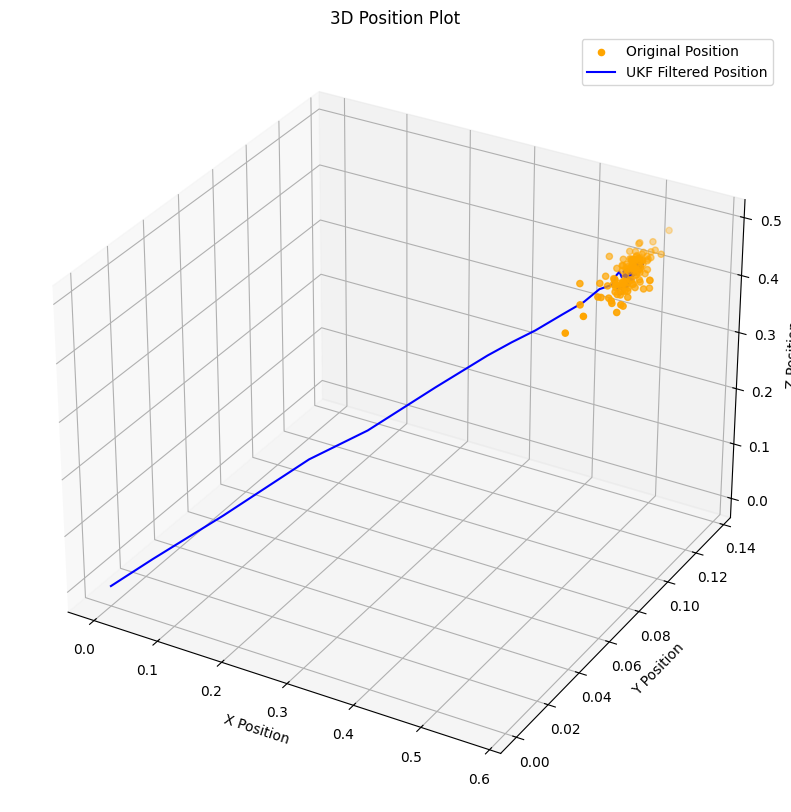

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from mpl_toolkits.mplot3d import Axes3D

# Define the state transition and measurement functions for the UKF
def fx(x, dt):
    return x  # Identity function for state transition (no dynamics in this simple case)

def hx(x):
    return x  # Identity function for measurement (we directly measure all states)

# Initialize the UKF parameters
dim_x = 4  # Number of state variables (x, y, z, yaw)
dim_z = 4  # Number of measurement variables (x, y, z, yaw)

# Define the sigma points
points = MerweScaledSigmaPoints(n=dim_x, alpha=0.05, beta=3.0, kappa=3-4)

# Initialize the UKF
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=fx, hx=hx, dt=1.0, points=points)

# Set the initial state
ukf.x = np.zeros(dim_x)  # Initialize with zeros or your prior_state

# Define initial covariance matrix
ukf.P *= 0.01

# Process noise covariance
ukf.Q = np.eye(dim_x)

ukf.R = np.eye(4) * 10
# Load the states from the saved file
states = np.load("states_no_filter1.npy")

# Extract positions and yaw
x_pos = states[:, 0]
y_pos = states[:, 1]
z_pos = states[:, 2]
yaw_angles = np.rad2deg(states[:, -1])  # Convert yaw from radians to degrees

# Combine into a single matrix for filtering
measurements = np.column_stack((x_pos, y_pos, z_pos, yaw_angles))

# Apply the UKF to the data
filtered_states = []

for i in range(len(measurements)):
    
    # UKF predict and update steps
    ukf.predict()
    ukf.update(measurements[i])
    # Store the filtered state
    filtered_states.append(ukf.x.copy())

# Convert filtered states to a numpy array
filtered_states = np.array(filtered_states)

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the original positions
ax.scatter(x_pos, y_pos, z_pos, c='orange', marker='o', label='Original Position')

# Plot the filtered positions
ax.plot(filtered_states[:, 0], filtered_states[:, 1], filtered_states[:, 2], color='blue', label='UKF Filtered Position')

# Set labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Position Plot')

# Add legend
ax.legend()

plt.show()


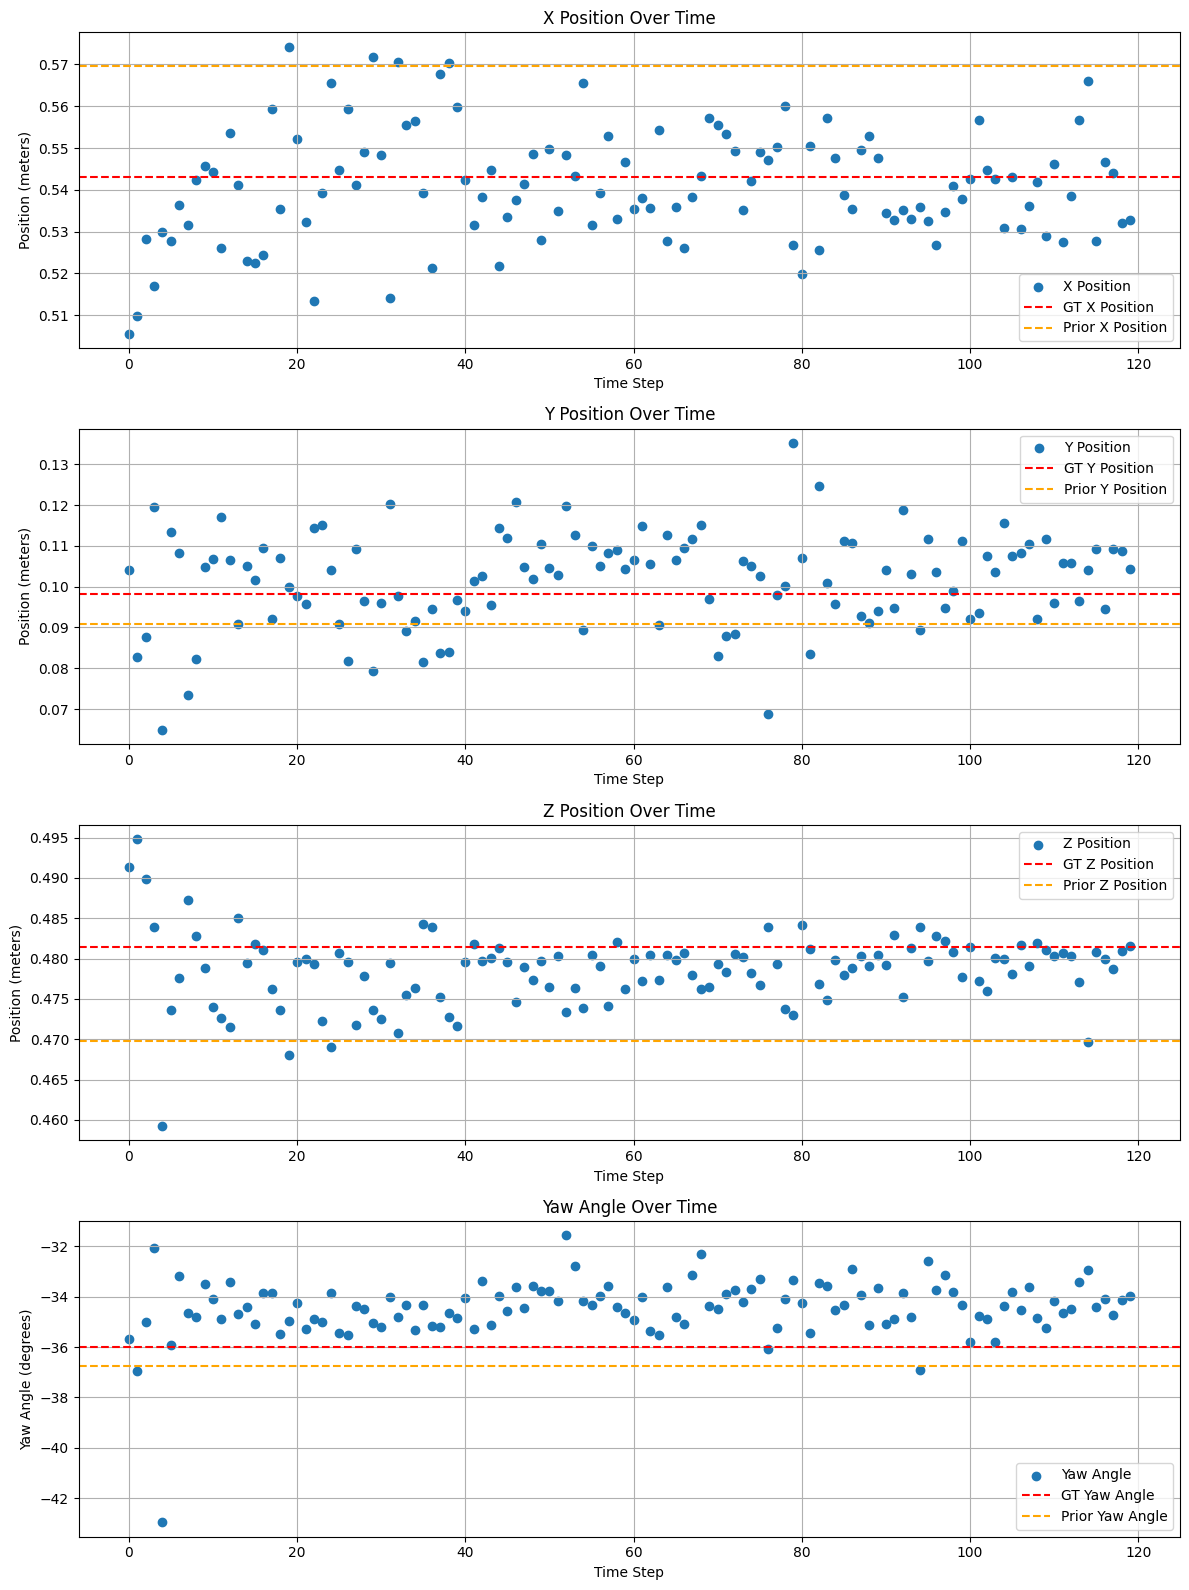

In [3]:
# Create subplots
fig, ax = plt.subplots(4, 1, figsize=(12, 16))

# Define common plot settings
plot_settings = [
    (x_pos, gt_pos[0], prior_pos[0], 'X Position', 'Position (meters)'),
    (y_pos, gt_pos[1], prior_pos[1], 'Y Position', 'Position (meters)'),
    (z_pos, gt_pos[2], prior_pos[2], 'Z Position', 'Position (meters)'),
    (yaw_angles, gt_yaw_angle, prior_yaw_angle, 'Yaw Angle', 'Yaw Angle (degrees)')
]

# Plot each subplot
for i, (pos, gt, prior, title, ylabel) in enumerate(plot_settings):
    ax[i].scatter(np.arange(states.shape[0]), pos, label=title, marker='o')
    ax[i].axhline(gt, color='red', linestyle='--', label=f'GT {title}')
    ax[i].axhline(prior, color='orange', linestyle='--', label=f'Prior {title}')
    ax[i].set_title(f'{title} Over Time')
    ax[i].set_xlabel('Time Step')
    ax[i].set_ylabel(ylabel)
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

[9.69196766e-05 8.32259197e-05 4.28982276e-06 6.46637615e-01]
[5.72338258e-05 2.63320172e-04 1.95807896e-05 4.01687501e+00]
[3.26642911e-05 4.99653117e-04 1.76145291e-04 2.11449292e+01]
[3.15554697e-05 5.94438105e-04 1.02940551e-04 2.02997394e+01]
[1.32345168e-05 4.71651021e-04 6.20482531e-05 1.68962535e+01]
[1.22645403e-05 3.13909782e-04 3.27079189e-05 1.25930164e+00]
[1.93108481e-05 2.18125547e-04 1.56562656e-05 5.24216381e-01]
[3.66815600e-05 1.73984622e-04 1.16833685e-05 3.27487251e-01]
[2.04300187e-06 1.23606331e-04 1.28400766e-05 2.77094606e-01]
[7.93122494e-05 2.85421291e-05 7.07050602e-06 3.15129482e-01]
[1.29542513e-04 2.39082883e-05 1.05931911e-06 3.51102278e-01]
[1.25647476e-04 1.15767177e-04 3.75827180e-05 4.14447790e-01]
[1.59150911e-04 4.97526489e-05 3.08633854e-05 2.93115461e-01]
[7.69452497e-05 3.66751005e-05 5.37429378e-06 7.37223299e-02]
[7.54222336e-07 1.02863595e-05 9.70351830e-07 2.43041239e-01]
[2.87238746e-04 5.04144834e-05 6.08197345e-06 3.24694180e-01]
[2.12555

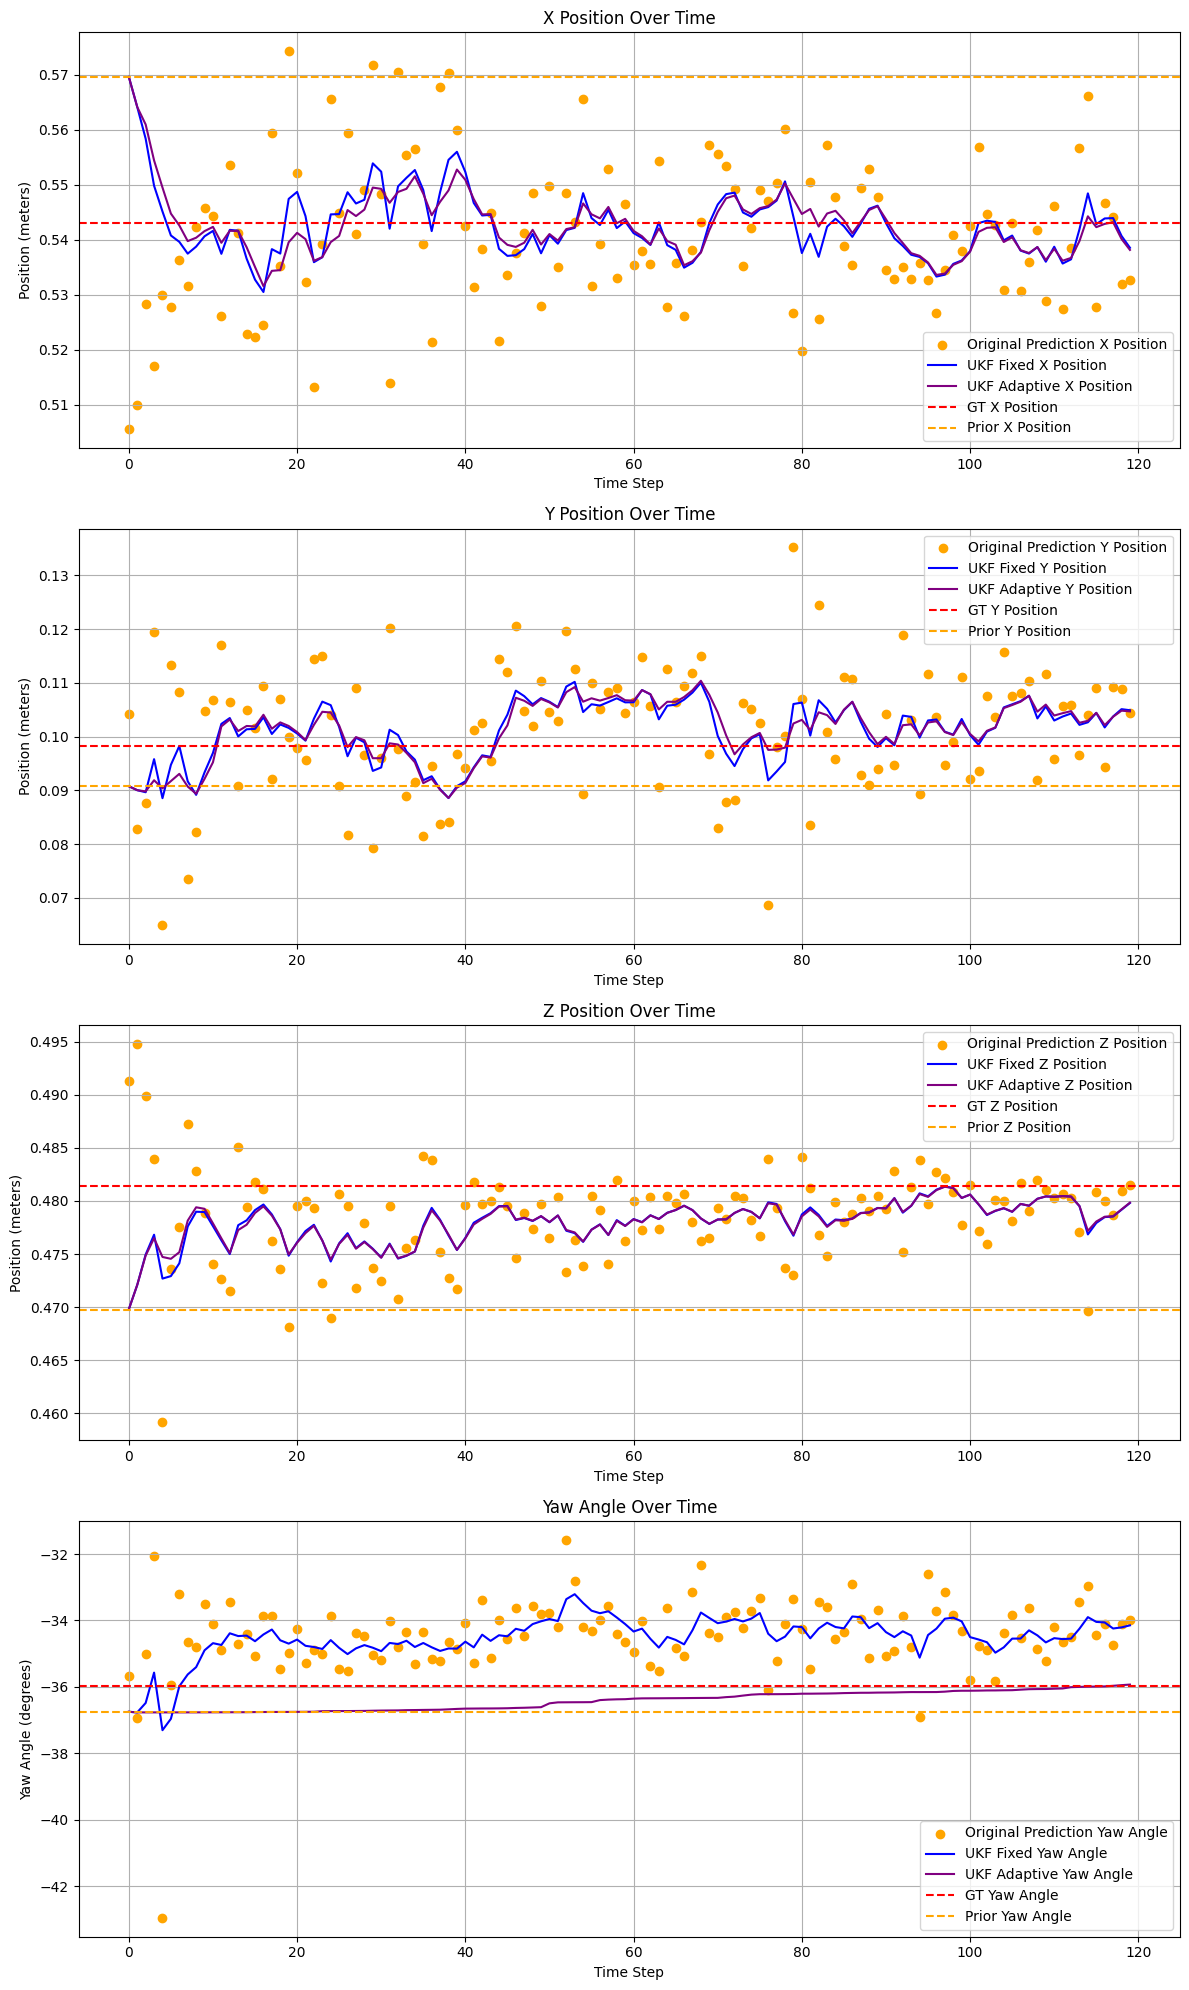

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from collections import deque

def update_ukf_adaptive(ukf, measurement, measurement_window):
    measurement_window.append(measurement)
    if len(measurement_window) == measurement_window.maxlen:
        # Calculate variance of measurements in the window
        windowed_measurements = np.array(measurement_window)
        measurement_variances = np.var(windowed_measurements, axis=0)
        
        print(measurement_variances)
        # Use these variances to adjust the measurement noise covariance
        ukf.R = np.diag(measurement_variances * 100000) + np.eye(dim_z) * 10
    
    ukf.predict()
    ukf.update(measurement)

# Define the state transition and measurement functions for the UKF
def fx(x, dt):
    return x  # Identity function for state transition (no dynamics in this simple case)

def hx(x):
    return x  # Identity function for measurement (we directly measure all states)

# Initialize the UKF parameters
dim_x = 4  # Number of state variables (x, y, z, yaw)
dim_z = 4  # Number of measurement variables (x, y, z, yaw)

# Define the sigma points
points = MerweScaledSigmaPoints(n=dim_x, alpha=0.05, beta=3.0, kappa=3-4)

# Initialize the two UKFs
ukf_fixed = UKF(dim_x=dim_x, dim_z=dim_z, fx=fx, hx=hx, dt=1.0, points=points)
ukf_adaptive = UKF(dim_x=dim_x, dim_z=dim_z, fx=fx, hx=hx, dt=1.0, points=points)

# Set the initial state
ukf_fixed.x = prior_state.copy()
ukf_adaptive.x = prior_state.copy()

# Define initial covariance matrix
ukf_fixed.P *= 0.01
ukf_adaptive.P *= 0.01

# Process noise covariance
ukf_fixed.Q = np.eye(dim_x) * 1
ukf_adaptive.Q = np.eye(dim_x) * 1

# Measurement noise covariance
ukf_fixed.R = np.eye(dim_z) * 10  # Fixed R for the first UKF
ukf_adaptive.R = np.eye(dim_z) * 10  # Initial R for the adaptive UKF

# Load the states from the saved file
states = np.load("states_no_filter1.npy")

# Extract positions and yaw
x_pos = states[:, 0]
y_pos = states[:, 1]
z_pos = states[:, 2]
yaw_angles = np.rad2deg(states[:, -1])  # Convert yaw from radians to degrees

# Combine into a single matrix for filtering
measurements = np.column_stack((x_pos, y_pos, z_pos, yaw_angles))

# Initialize data structures for filtered states
measurement_window = deque(maxlen=3)  # Window size of 3 for adaptive UKF
filtered_states_fixed = []
filtered_states_adaptive = []

# Real-time measurement loop
for measurement in measurements:
    # Apply the fixed UKF to the data
    ukf_fixed.predict()
    ukf_fixed.update(measurement)
    filtered_states_fixed.append(ukf_fixed.x.copy())
    
    # Apply the adaptive UKF to the data
    update_ukf_adaptive(ukf_adaptive, measurement, measurement_window)
    filtered_states_adaptive.append(ukf_adaptive.x.copy())

# Convert filtered states to numpy arrays
filtered_states_fixed = np.array(filtered_states_fixed)
filtered_states_adaptive = np.array(filtered_states_adaptive)

# Debugging information
print(f"filtered_states_fixed shape: {filtered_states_fixed.shape}")
print(f"filtered_states_adaptive shape: {filtered_states_adaptive.shape}")

# Define the plot settings for each state variable
plot_settings = [
    (x_pos, filtered_states_fixed[:, 0], filtered_states_adaptive[:, 0], 'X Position', 'Position (meters)'),
    (y_pos, filtered_states_fixed[:, 1], filtered_states_adaptive[:, 1], 'Y Position', 'Position (meters)'),
    (z_pos, filtered_states_fixed[:, 2], filtered_states_adaptive[:, 2], 'Z Position', 'Position (meters)'),
    (yaw_angles, filtered_states_fixed[:, 3], filtered_states_adaptive[:, 3], 'Yaw Angle', 'Yaw Angle (degrees)')
]

# Create subplots
fig, ax = plt.subplots(4, 1, figsize=(12, 20))

# Plot each subplot
for i, (pos, filt_fixed, filt_adaptive, title, ylabel) in enumerate(plot_settings):
    ax[i].scatter(np.arange(len(pos)), pos, label=f'Original Prediction {title}', marker='o', color='orange')
    ax[i].plot(np.arange(len(filt_fixed)), filt_fixed, label=f'UKF Fixed {title}', color='blue')
    ax[i].plot(np.arange(len(filt_adaptive)), filt_adaptive, label=f'UKF Adaptive {title}', color='purple')
    ax[i].axhline(gt_state[i], color='red', linestyle='--', label=f'GT {title}')
    ax[i].axhline(prior_state[i], color='orange', linestyle='--', label=f'Prior {title}')
    ax[i].set_title(f'{title} Over Time')
    ax[i].set_xlabel('Time Step')
    ax[i].set_ylabel(ylabel)
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()


In [158]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Define the state transition and measurement functions for the UKF
def fx(x, dt):
    return x  # Identity function for state transition (no dynamics in this simple case)

def hx(x):
    return x  # Identity function for measurement (we directly measure all states)

# Initialize the UKF parameters
dim_x = 4  # Number of state variables (x, y, z, yaw)
dim_z = 4  # Number of measurement variables (x, y, z, yaw)

# Define the sigma points
points = MerweScaledSigmaPoints(n=dim_x, alpha=0.05, beta=3.0, kappa=3-4)

# Load the states from the saved file
states = np.load("states_no_filter1.npy")

# Extract positions and yaw
x_pos = states[:, 0] * 100
y_pos = states[:, 1] * 100
z_pos = states[:, 2] * 100
yaw_angles = np.rad2deg(states[:, -1])  # Convert yaw from radians to degrees

# Combine into a single matrix for filtering
measurements = np.column_stack((x_pos, y_pos, z_pos, yaw_angles))

# Apply the UKF without adaptive measurement noise
ukf1 = UKF(dim_x=dim_x, dim_z=dim_z, fx=fx, hx=hx, dt=1.0, points=points)
ukf1.x = prior_state * 100
ukf1.P *= 0.01
ukf1.Q = np.eye(dim_x)
ukf1.R = np.eye(dim_z) * 1

filtered_states_no_adaptive = []
for i in range(len(measurements)):
    ukf1.predict()
    ukf1.update(measurements[i])
    filtered_states_no_adaptive.append(ukf1.x.copy())

filtered_states_no_adaptive = np.array(filtered_states_no_adaptive)

# Apply the UKF with adaptive measurement noise using moving variance
ukf2 = UKF(dim_x=dim_x, dim_z=dim_z, fx=fx, hx=hx, dt=1.0, points=points)
ukf2.x = prior_state  
ukf2.P *= 0.01
ukf2.Q = np.eye(dim_x)
ukf2.R = np.eye(dim_z) * 1

# Moving average window size and scaling factor
window_size = 10
alpha = 0.1
residuals_history = []
filtered_states_adaptive = []

for i in range(len(measurements)):
    ukf2.predict()
    
    # Update the measurement window
    measurement_window.append(measurements[i])
    if len(measurement_window) > window_size:
        measurement_window.pop(0)
    
    if len(measurement_window) == window_size:
        # Compute the variance of the measurements in the window
        avg_measurement_variance = np.var(measurement_window, axis=0)
        print(avg_measurement_variance)
        # Apply dynamic scaling to the measurement noise covariance matrix R
        ukf2.R = np.diag(avg_measurement_variance * 100 + np.ones(dim_z) * 1)

    # Update UKF with current measurement
    ukf2.update(measurements[i])
    filtered_states_adaptive.append(ukf2.x.copy())

filtered_states_adaptive = np.array(filtered_states_adaptive)

# Plot the results
plot_settings = [
    (x_pos, filtered_states_no_adaptive[:, 0], filtered_states_adaptive[:, 0], 'X Position', 'Position (meters)'),
    (y_pos, filtered_states_no_adaptive[:, 1], filtered_states_adaptive[:, 1], 'Y Position', 'Position (meters)'),
    (z_pos, filtered_states_no_adaptive[:, 2], filtered_states_adaptive[:, 2], 'Z Position', 'Position (meters)'),
    (yaw_angles, filtered_states_no_adaptive[:, 3], filtered_states_adaptive[:, 3], 'Yaw Angle', 'Yaw Angle (degrees)')
]

fig, ax = plt.subplots(4, 1, figsize=(12, 20))

for i, (pos, filt_no_adaptive, filt_adaptive, title, ylabel) in enumerate(plot_settings):
    ax[i].scatter(np.arange(states.shape[0]), pos, label=f'Original {title}', marker='o', color='orange')
    ax[i].plot(np.arange(states.shape[0]), filt_no_adaptive, label=f'UKF Filtered {title} (No Adaptive)', color='blue')
    ax[i].plot(np.arange(states.shape[0]), filt_adaptive, label=f'UKF Filtered {title} (Adaptive)', color='green')
    ax[i].set_title(f'{title} Over Time')
    ax[i].set_xlabel('Time Step')
    ax[i].set_ylabel(ylabel)
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()



filtered_states shape: (0,)
smoothed_states shape: (120, 4)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed